In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook',
        style='whitegrid',
        palette='deep',
        font='sans-serif',
        font_scale=1,
        color_codes=True,
        rc=None)


from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import datetime, os
from keras.preprocessing.sequence import TimeseriesGenerator

In [4]:
tf.__version__

'2.2.0'

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


# Loading Data

In [6]:
train_data = pd.read_csv('train_1.csv')
train = train_data
train.head(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


### Replacing nan values with forward fill

In [8]:
%%time
train = train.fillna(method='ffill', downcast='infer')
train.tail(3)

Wall time: 6.22 s


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,3,10,0,2,2,0,7,45,1,...,0,0,1,1,13,12,13,3,5,10
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,3,10,0,2,2,0,7,45,1,...,0,0,1,1,13,12,13,3,5,10
145062,Francisco_el_matemático_(serie_de_televisión_d...,3,10,0,2,2,0,7,45,1,...,0,0,1,1,13,12,13,3,5,10


### Converting data to integer values to reduce memory consumption

In [9]:
%%time
for cols in train.columns[1:]:
    train[cols] = pd.to_numeric(train[cols], downcast='integer')

Wall time: 5.88 s


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: int32(550), object(1)
memory usage: 305.5+ MB


# Transposing the dataframe with time stamps in index, and page names in columns

In [11]:
df = pd.DataFrame(train.iloc[:,1:].values.T,
            columns=train.Page.values, index=train.columns[1:])
df.index = pd.to_datetime(df.index, errors='ignore',
                                            dayfirst=False,
                                            yearfirst=False,
                                            utc=None,
                                            format="%Y/%m/%d",
                                            exact=False,
                                            unit=None,
                                            infer_datetime_format=True,
                                            origin='unix',
                                            cache=True)
df.head(3)

,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,5566_zh.wikipedia.org_all-access_spider,91Days_zh.wikipedia.org_all-access_spider,A'N'D_zh.wikipedia.org_all-access_spider,AKB48_zh.wikipedia.org_all-access_spider,ASCII_zh.wikipedia.org_all-access_spider,...,Drake_(músico)_es.wikipedia.org_all-access_spider,Skam_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Legión_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Doble_tentación_es.wikipedia.org_all-access_spider,Mi_adorable_maldición_es.wikipedia.org_all-access_spider,Underworld_(serie_de_películas)_es.wikipedia.org_all-access_spider,Resident_Evil:_Capítulo_Final_es.wikipedia.org_all-access_spider,Enamorándome_de_Ramón_es.wikipedia.org_all-access_spider,Hasta_el_último_hombre_es.wikipedia.org_all-access_spider,Francisco_el_matemático_(serie_de_televisión_de_2017)_es.wikipedia.org_all-access_spider
2015-07-01,18,11,1,35,35,12,12,118,5,6,...,3,3,3,3,3,3,3,3,3,3
2015-07-02,11,14,0,13,13,7,7,26,23,3,...,10,10,10,10,10,10,10,10,10,10
2015-07-03,5,15,1,10,10,4,4,30,14,5,...,0,0,0,0,0,0,0,0,0,0


### List of different types of webpages

In [12]:
list(df.columns)[:10]  # First 10 pages

['2NE1_zh.wikipedia.org_all-access_spider',
 '2PM_zh.wikipedia.org_all-access_spider',
 '3C_zh.wikipedia.org_all-access_spider',
 '4minute_zh.wikipedia.org_all-access_spider',
 '52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider',
 '5566_zh.wikipedia.org_all-access_spider',
 '91Days_zh.wikipedia.org_all-access_spider',
 "A'N'D_zh.wikipedia.org_all-access_spider",
 'AKB48_zh.wikipedia.org_all-access_spider',
 'ASCII_zh.wikipedia.org_all-access_spider']

### Creating Separate Dataframe for Wikipedia hits

In [13]:
wikipedia = (df.filter(like='wikipedia'))
wikipedia

,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,5566_zh.wikipedia.org_all-access_spider,91Days_zh.wikipedia.org_all-access_spider,A'N'D_zh.wikipedia.org_all-access_spider,AKB48_zh.wikipedia.org_all-access_spider,ASCII_zh.wikipedia.org_all-access_spider,...,Drake_(músico)_es.wikipedia.org_all-access_spider,Skam_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Legión_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Doble_tentación_es.wikipedia.org_all-access_spider,Mi_adorable_maldición_es.wikipedia.org_all-access_spider,Underworld_(serie_de_películas)_es.wikipedia.org_all-access_spider,Resident_Evil:_Capítulo_Final_es.wikipedia.org_all-access_spider,Enamorándome_de_Ramón_es.wikipedia.org_all-access_spider,Hasta_el_último_hombre_es.wikipedia.org_all-access_spider,Francisco_el_matemático_(serie_de_televisión_de_2017)_es.wikipedia.org_all-access_spider
2015-07-01,18,11,1,35,35,12,12,118,5,6,...,3,3,3,3,3,3,3,3,3,3
2015-07-02,11,14,0,13,13,7,7,26,23,3,...,10,10,10,10,10,10,10,10,10,10
2015-07-03,5,15,1,10,10,4,4,30,14,5,...,0,0,0,0,0,0,0,0,0,0
2015-07-04,13,18,1,94,94,5,5,24,12,12,...,2,2,2,2,2,2,2,2,2,2
2015-07-05,14,11,0,4,4,20,20,29,9,6,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,20,30,4,11,11,19,4,23,30,29,...,8,7,4,4,4,12,12,12,12,12
2016-12-28,22,52,6,17,27,23,15,32,36,35,...,21,13,2,2,2,13,13,13,13,13
2016-12-29,19,45,3,19,13,17,6,39,38,44,...,14,12,4,4,4,3,3,3,3,3
2016-12-30,18,26,4,10,36,17,8,32,31,26,...,24,31,4,4,4,5,5,5,5,5


# Plotting 1st 10 page hits

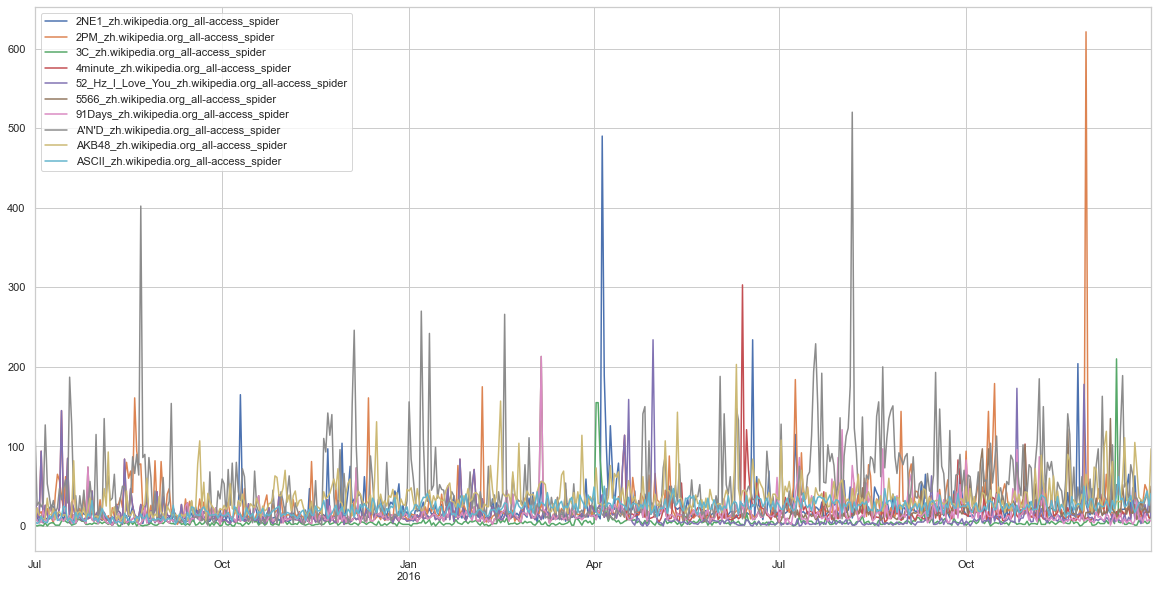

In [14]:
wikipedia.iloc[:,0:10].plot(figsize=(20,10))
plt.show()

### Languages of wikipedia pages

In [15]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'other'

(wikipedia.columns.map(get_language)).unique()

Index(['zh', 'fr', 'en', 'other', 'ru', 'de', 'ja', 'es'], dtype='object')

In [16]:
len((wikipedia.columns.map(get_language)).unique())

8

In [17]:
languages = list((wikipedia.columns.map(get_language)).unique())
languages.remove('other')
languages

['zh', 'fr', 'en', 'ru', 'de', 'ja', 'es']

### Creating Separate Dataframes for every language of wikipedia pages

In [18]:
for lang in (languages):
    locals()['lang_'+str(lang)] = wikipedia.loc[:, wikipedia.columns.str.contains('_'+str(lang)+'.wiki')]

In [19]:
lang_en.head(3)

,!vote_en.wikipedia.org_desktop_all-agents,"""Awaken,_My_Love!""_en.wikipedia.org_desktop_all-agents","""European_Society_for_Clinical_Investigation""_en.wikipedia.org_desktop_all-agents","""Weird_Al""_Yankovic_en.wikipedia.org_desktop_all-agents",100_metres_en.wikipedia.org_desktop_all-agents,10_Cloverfield_Lane_en.wikipedia.org_desktop_all-agents,10_Gigabit_Ethernet_en.wikipedia.org_desktop_all-agents,13_Hours:_The_Secret_Soldiers_of_Benghazi_en.wikipedia.org_desktop_all-agents,1551_en.wikipedia.org_desktop_all-agents,1896_Summer_Olympics_en.wikipedia.org_desktop_all-agents,...,Zgornji_Lehen_na_Pohorju_en.wikipedia.org_all-access_all-agents,Zhao_Lin_en.wikipedia.org_all-access_all-agents,Zhejiang_Yueju_Troupe_en.wikipedia.org_all-access_all-agents,Zheleznogorsk_Airport_en.wikipedia.org_all-access_all-agents,Zhu_Qingyuan_en.wikipedia.org_all-access_all-agents,Zikanyrops_sparsa_en.wikipedia.org_all-access_all-agents,Zillur_Rahman_John_en.wikipedia.org_all-access_all-agents,Zitadelle_en.wikipedia.org_all-access_all-agents,"Zovashen_(Dzhannatlu),_Ararat_en.wikipedia.org_all-access_all-agents",Zurich.minds_en.wikipedia.org_all-access_all-agents
2015-07-01,3,3,3,2403,982,982,1078,1078,11,366,...,1,3,3,3,3,1,7,10,10,8
2015-07-02,4,4,4,20136,881,881,1116,45,9,392,...,1,1,1,5,1,5,9,6,6,5
2015-07-03,7,7,7,1850,794,794,869,462,19,322,...,1,2,1,4,2,2,3,4,1,7


In [20]:
for lang in (languages):
    locals()['hits_'+str(lang)] = np.array(locals()['lang_'+str(lang)].iloc[:,:].sum(axis=1))

In [21]:
for lang in (languages):
    print((locals()['hits_'+str(lang)]).shape)

(550,)
(550,)
(550,)
(550,)
(550,)
(550,)
(550,)


In [22]:
keys = languages
values = ['Chinese', 'French', 'English', 'Russian', 'German', 'Japanese', 'Spanish']

In [23]:
d = dict(zip(keys,values))

In [24]:
index = wikipedia.index

hits = pd.DataFrame(index=index, columns=list(d.values()))
hits = hits.fillna(0)

In [25]:
for key, value in d.items():
    hits[value] = locals()['hits_'+str(key)]

In [26]:
hits

,Chinese,French,English,Russian,German,Japanese,Spanish
2015-07-01,5456207,31228817,120391534,9801685,15081056,12029356,16103942
2015-07-02,4269619,8861578,119093656,9740966,14775940,13803809,15424574
2015-07-03,4427445,8511084,113155589,9005289,14216769,12371482,13831014
2015-07-04,4268193,9441573,117289794,8498550,12797849,15725650,12986072
2015-07-05,4559700,8958291,122355756,9658335,14941068,15235858,14225614
...,...,...,...,...,...,...,...
2016-12-27,6520782,15306059,146302021,15073578,21196967,16745293,16491574
2016-12-28,6575150,13822342,142185728,14034697,20203002,16795504,17200073
2016-12-29,6103644,13420548,151236461,13514914,19378955,18305166,16168558
2016-12-30,6204629,12496021,125827146,12098492,18494742,19578058,11774502


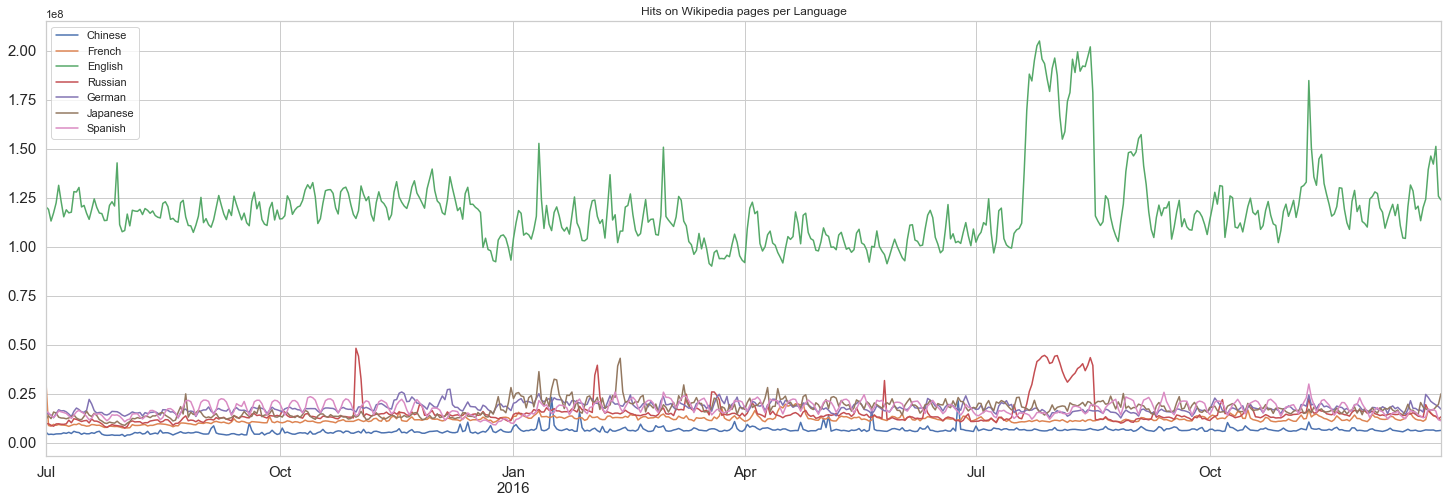

In [27]:
hits.plot(figsize=(25,8), title ='Hits on Wikipedia pages per Language', fontsize=15)
plt.legend(loc='upper left')
plt.show()

## Auto Correlation
It is showing that data points even after lag of 25 is also relevant.

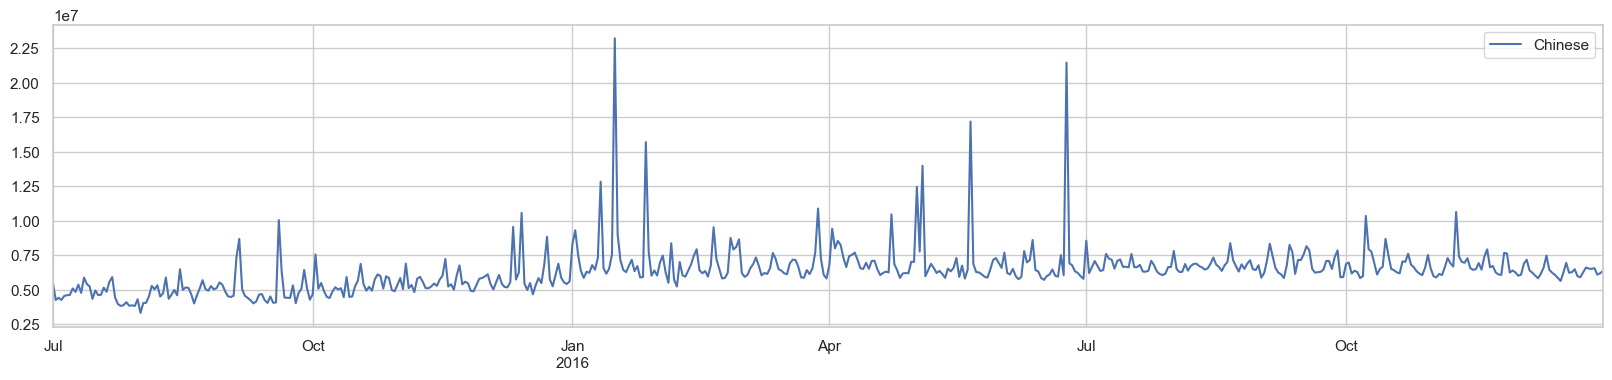

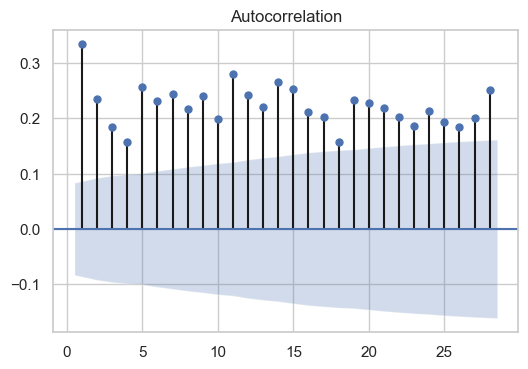

In [28]:
plt.rcParams["figure.dpi"] = 100
hits.iloc[:,0:1].plot(figsize=(20,4))
sgt.plot_acf(np.array(hits.iloc[:,0:1]),
            ax=None,
            lags=None,
            alpha=0.05,
            use_vlines=True,
            unbiased=False,
            fft=False,
            missing='none',
            title='Autocorrelation',
            zero=False,  # Not including the 1st term as its acf w.r.t. itself will always be 1.
            vlines_kwargs=None)
plt.show()

## Partial Auto-correlation
Shows that upto 11 lags, the data points are relvant.

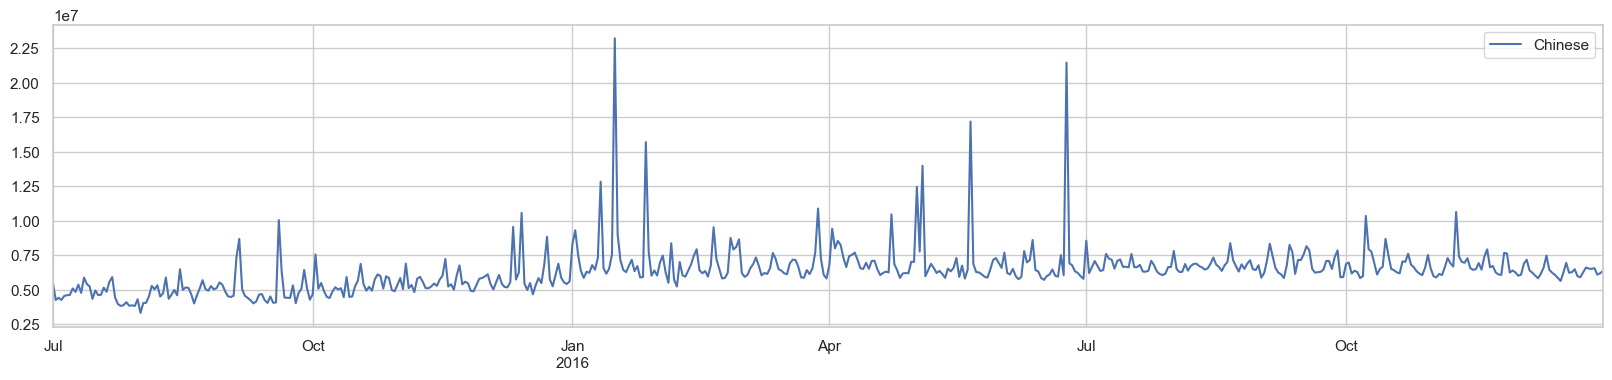

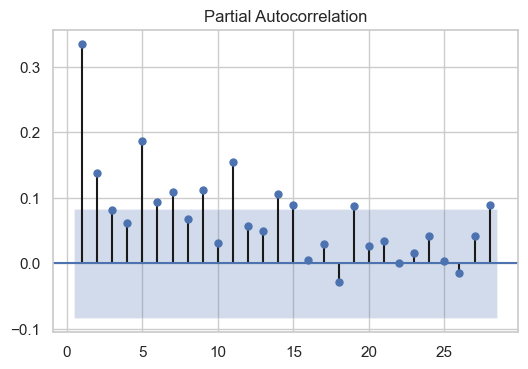

In [29]:
plt.rcParams["figure.dpi"] = 100
hits.iloc[:,0:1].plot(figsize=(20,4))
sgt.plot_pacf(np.array(hits.iloc[:,0:1]),
            ax=None,
            lags=None,
            alpha=0.05,
            method='ols',
            use_vlines=True,
            title='Partial Autocorrelation',
            zero=False,    # Not including the 1st term as its pacf w.r.t. itself will always be 1.
            vlines_kwargs=None)
plt.show()

## Train-Test Split

In [30]:
brk = 0.8
data_split = int(len(hits)*brk)
data_split

440

In [31]:
X, y = hits.iloc[:data_split,:], hits.iloc[data_split:,:]

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)

scaled_X = scaler.transform(X)
scaled_y = scaler.transform(y)

In [33]:
print(scaled_X.max(), scaled_X.min())
print(scaled_y.max(), scaled_y.min())

1.0 0.0
1.247600801777848 0.056305299568402356


In [34]:
X_df = (pd.DataFrame(scaled_X))
y_df = (pd.DataFrame(scaled_y))

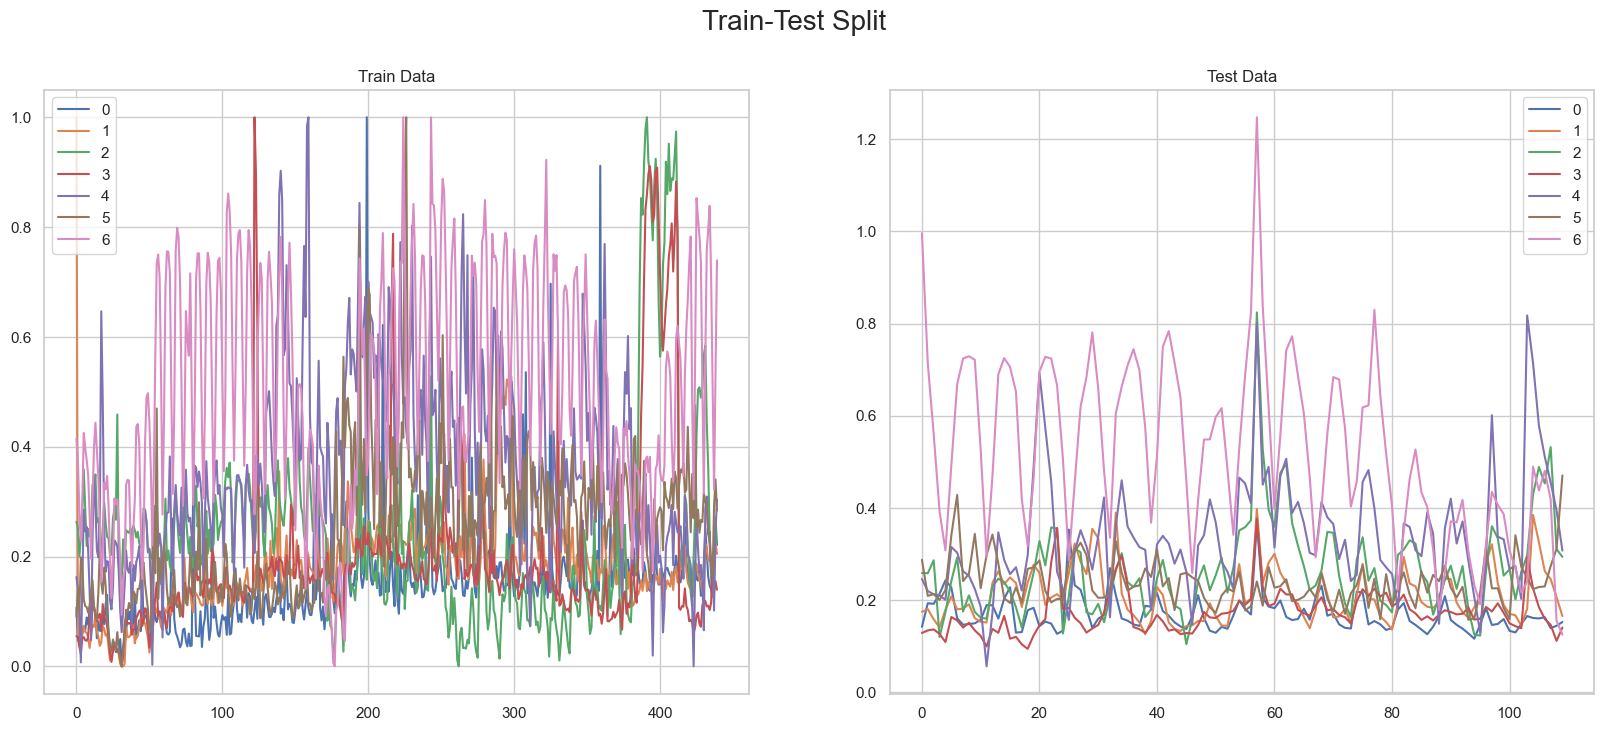

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=100)
plt.suptitle('Train-Test Split', fontsize=20)
X_df.plot(ax=axes[0], title='Train Data')
y_df.plot(ax=axes[1], title='Test Data')

plt.show()

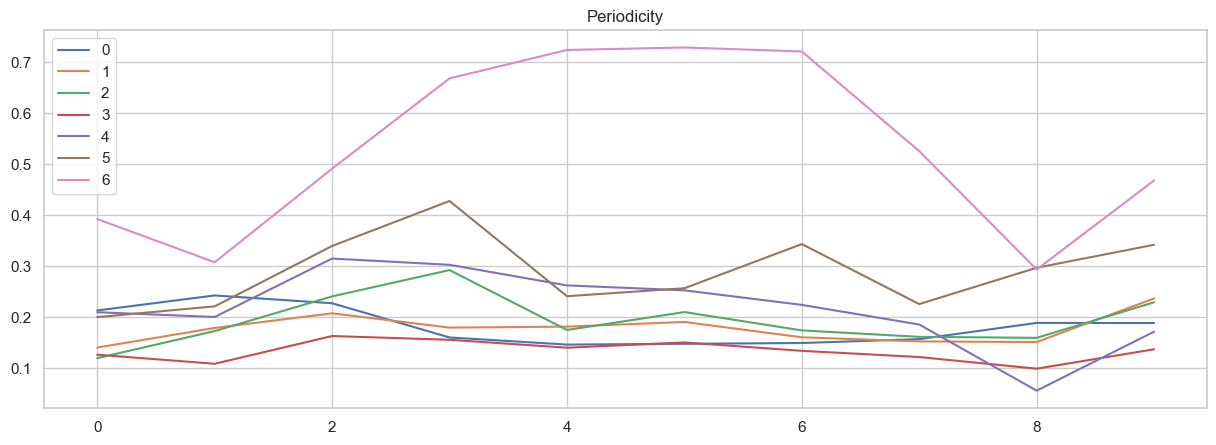

In [36]:
pd.DataFrame(scaled_y[3:13,:]).plot(figsize=(15,5), title='Periodicity')
plt.show()

In [37]:
print(scaled_X.shape)
print(scaled_y.shape)
print('No. of features = '+str(scaled_X.shape[1]))
print('No. of train instances = '+str(scaled_X.shape[0]))
print('No. of test instances = '+str(scaled_y.shape[0]))

(440, 7)
(110, 7)
No. of features = 7
No. of train instances = 440
No. of test instances = 110


# LSTM 
## (Predicting on sum of web hits of wikipedia pages per language)

### Time Series Generator
#### From ACF and PACF plots, it is optimal to select a time sequence of 7-10 time stamps. The reason of choosing 7 is for weekly cycle.

In [38]:
length = 7
batch = 1

n_features = scaled_X.shape[1]
n_features

7

In [39]:
generator = TimeseriesGenerator(data = scaled_X,
                                targets = scaled_X,
                                length = length,
                                sampling_rate=1,
                                stride=1,
                                start_index=0,
                                end_index=None,
                                shuffle=False,
                                reverse=False,
                                batch_size=batch)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import datetime, os

model = Sequential(layers=None, name="LSTM_Model")

model.add(LSTM( units = 400,               
                activation='tanh',
                input_shape=( length, n_features),                
                recurrent_activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                recurrent_initializer='orthogonal',
                bias_initializer='zeros',
                unit_forget_bias=True,
                kernel_regularizer=None,
                recurrent_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                recurrent_constraint=None,
                bias_constraint=None,
                dropout=0.0,
                recurrent_dropout=0.0,
                implementation=2,
                return_sequences=True,
                return_state=False,
                go_backwards=False,
                stateful=False,
                time_major=False,
                unroll=False
            ) )
model.add(LSTM(units = 500, return_sequences=True))

model.add(LSTM(units = 500, return_sequences=False))

model.add(Dense(700, activation="relu", name="layer1"))

model.add(Dense(100, activation="relu", name="layer2"))

model.add(Dense( units = n_features,               
    activation='relu',
    use_bias=True,                        
    kernel_initializer='glorot_uniform',  
    bias_initializer='zeros',             
    kernel_regularizer=None,              
    bias_regularizer=None,                
    activity_regularizer=None,            
    kernel_constraint=None,               
    bias_constraint=None))                



model.compile(optimizer='adam', loss='mse')

In [41]:
model.summary()

Model: "LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 400)            652800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 500)            1802000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
layer1 (Dense)               (None, 700)               350700    
_________________________________________________________________
layer2 (Dense)               (None, 100)               70100     
_________________________________________________________________
dense (Dense)                (None, 7)                 707       
Total params: 4,878,307
Trainable params: 4,878,307
Non-trainable params: 0
______________________________________________

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=30,
                        verbose=1,  
                        mode='auto',
                        baseline=None,  
                                               
                        restore_best_weights=False)

In [43]:
validation_generator = TimeseriesGenerator(scaled_y,scaled_y, length=length, batch_size=batch)

In [44]:
%%time
history = model.fit(generator,
                    steps_per_epoch=None,
                    epochs=300,
                    verbose=1,
                    callbacks=[early_stop],
                    validation_data = validation_generator,
                    validation_steps=None,
                    validation_freq=1,
                    class_weight=None,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False,
                    shuffle=True,
                    initial_epoch=0)

Epoch 1/300
433/433 [==============================] - 6s 14ms/step - loss: 0.0357 - val_loss: 0.0140
Epoch 2/300
433/433 [==============================] - 5s 12ms/step - loss: 0.0228 - val_loss: 0.0146
Epoch 3/300
433/433 [==============================] - 5s 12ms/step - loss: 0.0226 - val_loss: 0.0116
Epoch 4/300
433/433 [==============================] - 5s 13ms/step - loss: 0.0172 - val_loss: 0.0103
Epoch 5/300
433/433 [==============================] - 5s 13ms/step - loss: 0.0135 - val_loss: 0.0089
Epoch 6/300
433/433 [==============================] - 5s 12ms/step - loss: 0.0126 - val_loss: 0.0073
Epoch 7/300
433/433 [==============================] - 5s 12ms/step - loss: 0.0100 - val_loss: 0.0078
Epoch 8/300
433/433 [==============================] - 5s 12ms/step - loss: 0.0093 - val_loss: 0.0074
Epoch 9/300
433/433 [==============================] - 5s 12ms/step - loss: 0.0103 - val_loss: 0.0074
Epoch 10/300
433/433 [==============================] - 5s 12ms/step - loss: 0.010

433/433 [==============================] - 5s 13ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 81/300
433/433 [==============================] - 5s 12ms/step - loss: 0.0021 - val_loss: 0.0066
Epoch 82/300
433/433 [==============================] - 5s 13ms/step - loss: 0.0017 - val_loss: 0.0060
Epoch 83/300
433/433 [==============================] - 5s 12ms/step - loss: 0.0016 - val_loss: 0.0083
Epoch 00083: early stopping
Wall time: 7min 36s


In [45]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


In [46]:
losses = pd.DataFrame(model.history.history)

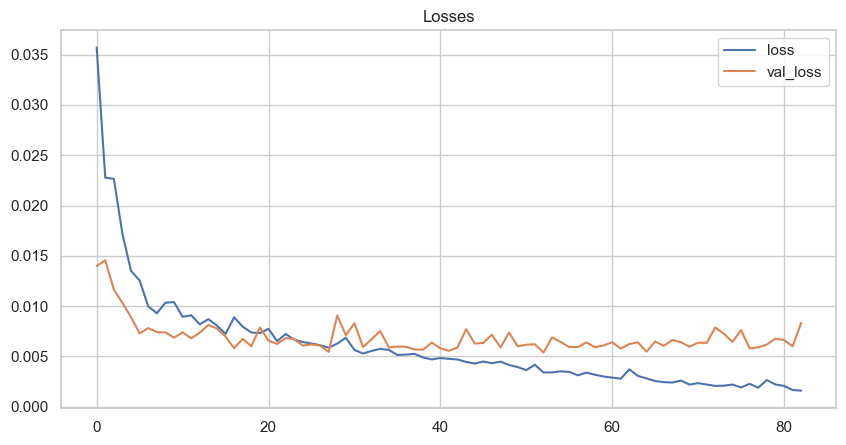

In [47]:
plt.rcParams["figure.dpi"] = 100
losses.plot(figsize=(10,5))
plt.title('Losses')
plt.show()

#### Predictions

In [48]:
%%time
test_predictions = []

first_eval_batch = scaled_X[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_y)):
    
    current_pred = model.predict(current_batch,verbose=0)[0]
    
    test_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

Wall time: 3.09 s


In [49]:
print(np.array(test_predictions).shape)
print(scaled_y.shape)

(110, 7)
(110, 7)


In [50]:
print(np.array(test_predictions).max(), np.array(test_predictions).min())
print(scaled_y.max(), scaled_y.min())

0.9623599 0.058701202
1.247600801777848 0.056305299568402356


In [51]:
true_predictions = scaler.inverse_transform(test_predictions)
print(true_predictions.shape)

(110, 7)


In [52]:
print(np.array(true_predictions).max(), np.array(true_predictions).min())
print(np.array(y).max(), np.array(y).min())

126700203.54424977 5892558.777234912
184806511 5646281


In [53]:
t_l = len(scaled_y)
t_l

110

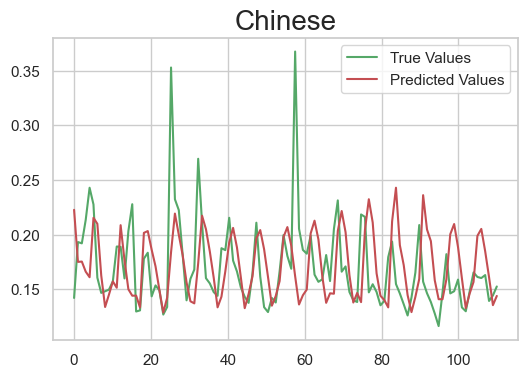

In [54]:
plt.figure(dpi=100)
plt.plot(np.linspace(0,t_l,t_l), scaled_y[:,0:1] , label='True Values',c='g')
plt.plot(np.linspace(0,t_l,t_l), np.array(test_predictions)[:,0:1], label='Predicted Values',c='r')
plt.title(hits.columns[0], fontsize=20)
plt.legend()
plt.show()

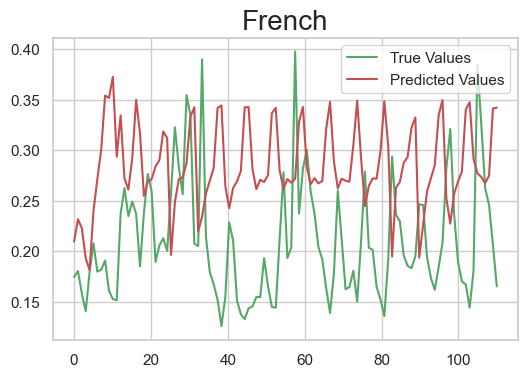

In [55]:
plt.plot(np.linspace(0,t_l,t_l), scaled_y[:,1:2] , label='True Values',c='g')
plt.plot(np.linspace(0,t_l,t_l), np.array(test_predictions)[:,1:2], label='Predicted Values',c='r')
plt.title(hits.columns[1], fontsize=20)
plt.legend()
plt.show()

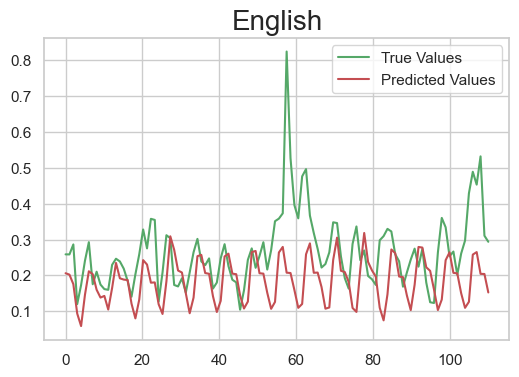

In [56]:
plt.plot(np.linspace(0,t_l,t_l), scaled_y[:,2:3] , label='True Values',c='g')
plt.plot(np.linspace(0,t_l,t_l), np.array(test_predictions)[:,2:3], label='Predicted Values',c='r')
plt.title(hits.columns[2], fontsize=20)
plt.legend()
plt.show()

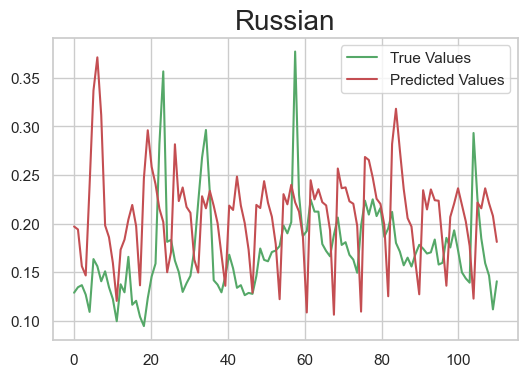

In [57]:
plt.plot(np.linspace(0,t_l,t_l), scaled_y[:,3:4] , label='True Values',c='g')
plt.plot(np.linspace(0,t_l,t_l), np.array(test_predictions)[:,3:4], label='Predicted Values',c='r')
plt.title(hits.columns[3], fontsize=20)
plt.legend()
plt.show()

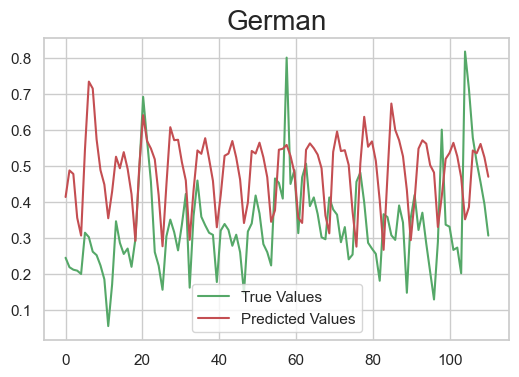

In [58]:
plt.plot(np.linspace(0,t_l,t_l), scaled_y[:,4:5] , label='True Values',c='g')
plt.plot(np.linspace(0,t_l,t_l), np.array(test_predictions)[:,4:5], label='Predicted Values',c='r')
plt.title(hits.columns[4], fontsize=20)
plt.legend()
plt.show()

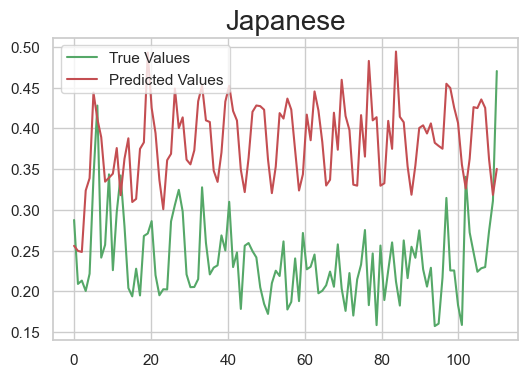

In [59]:
plt.plot(np.linspace(0,t_l,t_l), scaled_y[:,5:6] , label='True Values',c='g')
plt.plot(np.linspace(0,t_l,t_l), np.array(test_predictions)[:,5:6], label='Predicted Values',c='r')
plt.title(hits.columns[5], fontsize=20)
plt.legend()
plt.show()

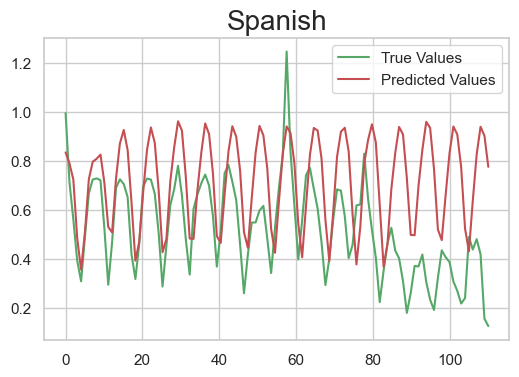

In [60]:
plt.plot(np.linspace(0,t_l,t_l), scaled_y[:,6:7] , label='True Values',c='g')
plt.plot(np.linspace(0,t_l,t_l), np.array(test_predictions)[:,6:7], label='Predicted Values',c='r')
plt.title(hits.columns[6], fontsize=20)
plt.legend()
plt.show()

## Inference:
It can be infered that prediction on the chinese wikipedia pages has been the best. Now it can be improved by tweaking the LSTM architecture and the length of time sequence to be fed. The model has been tested with 440 training instances, which is too low, and tested on 110 instances. No. of features is 7.